# Step 3 of the Workshop 


## Contents
1. [Introduction](#Introduction)
1. [Step 3 - ML With SageMaker](#Step-3---ML-With-SageMaker)
    1. [Setup](#Setup-and-How-to-Instructions)
    1. [Redshift Data API](#Redshit-Data-API)
    1. [Data Exploration](#Data-Exploration)
    1. [Amazon SageMaker Model Training](#Amazon-SageMaker-Model-Training)
        1. [Create Model](#Create-Model)
        1. [Create Amazon SageMaker Endpoint](#Create-Amazon-SageMaker-Endpoint)
1. [Bring Remote Model to Redshift](#Bring-Remote-Model-to-Redshift)
    1. [Create BYOM](#Create-BYOM)
    


---

# Introduction

Using Amazon Sagemaker Studio we are going to complete Step 3.  Step 3 is about training and creating a Random Cut Forest Machine Model using Amazon Sagemaker.
***

# Step 3 - ML With SageMaker

Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. More details about the data set can be found here [Campaign Data set](https://archive.ics.uci.edu/ml/datasets/bank+marketing)

# Setup and How to Instructions

This notebook uses below parameters which are set by running below code.   

1. REDSHIFT_IAM_ROLE: The IAM role arn attached to Redshift Cluster.
2. REDSHIFT_USER: Database users to run SQL commands
3. REDSHIFT_ENDPOINT: Redshift Cluster end point.
4. SAGEMAKER_S3_BUCKET: S3 Bucket to store training input/output

## How to Run the commands:
Select your cell and hit **Shift+Enter** or Click on Run button from menu options.</br>
Cell is finished running when * turns into a Number.


### Import Libraries and setup buckets

In [1]:
import boto3
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import botocore
import sagemaker
import sys


session = boto3.session.Session()
region = session.region_name

def get_workshop_parameters():
    s3 = boto3.client('s3')
    response = s3.list_buckets()
    for bucket in response['Buckets']:
        print('1-',bucket)
        if 'mod' in bucket["Name"]:
            s3_bucket= bucket["Name"]
            print('2-',s3_bucket)
            break
    obj = s3.get_object(Bucket=s3_bucket, Key='workshop/sagemaker_config.json')
    config = json.loads(obj['Body'].read().decode('utf-8'))
    return config

config = get_workshop_parameters()

REDSHIFT_IAM_ROLE=config.get('REDSHIFT_IAM_ROLE')
REDSHIFT_USER=config.get('REDSHIFT_USER')
REDSHIFT_ENDPOINT = config.get('REDSHIFT_ENDPOINT')
SAGEMAKER_S3_BUCKET=config.get('SAGEMAKER_S3_BUCKET')
SAGEMAKER_ENDPOINT=config.get('SAGEMAKER_ENDPOINT')

bucket = SAGEMAKER_S3_BUCKET
prefix = "sagemaker/rcf-marketing-campaign"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

1- {'Name': 'mod-4d97d0e707c84ed8-redshifts3bucket-1l7ieun44asq', 'CreationDate': datetime.datetime(2021, 10, 22, 3, 31, 32, tzinfo=tzlocal())}
2- mod-4d97d0e707c84ed8-redshifts3bucket-1l7ieun44asq


## Redshift Data API

In this step, we are creating function run_sql, which we will use to get SQL query output directly into pandas dataframe. We will also use this function to run DDL statements

In [2]:
def run_sql(sql_text):
    client = boto3.client("redshift-data")
    res = client.execute_statement(Database=REDSHIFT_ENDPOINT.split('/')[1], DbUser=REDSHIFT_USER, Sql=sql_text,
                                   ClusterIdentifier=REDSHIFT_ENDPOINT.split('.')[0])
    query_id = res["Id"]
    done = False
    while not done:
        time.sleep(1)
        status_description = client.describe_statement(Id=query_id)
        status = status_description["Status"]
        if status == "FAILED":
            raise Exception('SQL query failed:' + query_id + ": " + status_description["Error"])
        elif status == "FINISHED":
            if status_description['ResultRows']>0:
                results = client.get_statement_result(Id=query_id)
                metadata=dict()
                column_labels = []
                #dtypes = []
                for i in range(len(results["ColumnMetadata"])): column_labels.append(results["ColumnMetadata"][i]['label'])
                for i in range(len(results["ColumnMetadata"])): 
                    if (results["ColumnMetadata"][i]['typeName'])=='varchar':
                        typ='str'
                    elif ((results["ColumnMetadata"][i]['typeName'])=='int4' or (results["ColumnMetadata"][i]['typeName'])=='numeric') :
                        typ='float'
                    else:
                        typ = 'str'
                    metadata[results["ColumnMetadata"][i]['label']]=typ            
                    #dtypes.append(typ)
                 
                
                records = []
                
                for record in results.get('Records'):
                    records.append([list(rec.values())[0] for rec in record])
                df = pd.DataFrame(np.array(records), columns=column_labels)
                df = df.astype(metadata)
                return df
            else:
                return query_id


## Data Exploration

Data set is alerady loaded on Amazon Data warehouse.  Kim loads the campaign data-set into a Data frame using a call to Redshift Data API and explore it.


In [3]:
marketing_data = run_sql('Select * from marketing_campaign_raw_data ;')
marketing_data.head(5)

,customerid,serialnumber,age,job,marital,education,is_default,balance,housing,loan,contact,day,month,duration,campaign,days_since_last_contact,previous,poutcome,accepted
0,0178-SZBHO,102.0,40.0,entrepreneur,married,tertiary,no,3571.0,no,no,unknown,9.0,jun,222.0,3.0,-1.0,0.0,unknown,no
1,0181-RITDD,103.0,48.0,technician,divorced,secondary,yes,20.0,no,no,cellular,27.0,aug,145.0,3.0,-1.0,0.0,unknown,no
2,0186-CAERR,104.0,51.0,unemployed,married,tertiary,no,1634.0,yes,no,cellular,22.0,jul,168.0,4.0,-1.0,0.0,unknown,no
3,0187-QSXOE,105.0,27.0,admin.,married,secondary,no,-247.0,yes,yes,unknown,4.0,jun,344.0,2.0,-1.0,0.0,unknown,no
4,0187-WZNAB,106.0,32.0,unemployed,single,secondary,no,0.0,no,no,cellular,27.0,may,123.0,2.0,-1.0,0.0,unknown,no


#### Investigate the data.  
Look for patterns or issues in underlying data. Balance attribute shows significant spike.

<AxesSubplot:>

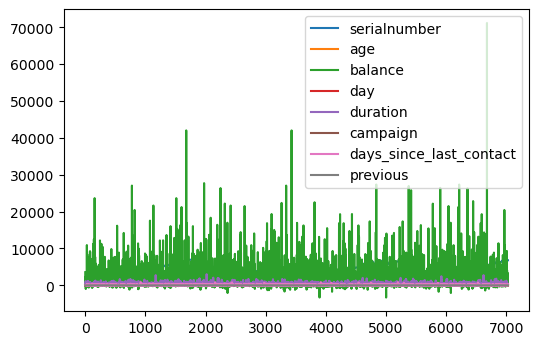

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 100

marketing_data.plot()

### Preparing the data for Machine Learning 

For machine learning model we need to one hot encode the values, marketing_campaing data set is already hot encoded using Redshift SQL and is in view marketing_campaign_encoded_data.  Kim loads this data into a data frame to train the Random Cut Forest Model.


In [5]:
marketing_encoded_data = run_sql("""
select
    age, 
    balance, 
    day,
    duration,
    campaign,
    days_since_last_contact,
    previous,
    case when job ='blue-collar' then 1 else 0 end as job_blue_collor,
    case when job ='entrepreneur' then 1 else 0 end as job_entrepreneur,
    case when job ='housemaid' then 1 else 0 end as job_housemaid,
    case when job ='management' then 1 else 0 end as job_management,
    case when job ='retired' then 1 else 0  end as job_retired,
    case when job ='self-employed' then 1 else 0  end as job_self_employed,
    case when job ='student'then 1 else 0  end as job_student,
    case when job ='technician' then 1 else 0  end as job_technician,
     case when job ='unemployed' then 1 else 0 end as job_unemployed,
    case when job ='unknown' then 1 else 0 end as job_unknown,
    case when job ='services' then 1 else 0  end as job_services,
    case when month='jan' Then 1 else 0 end as month_jan,
    case when month='feb' Then 1 else 0 end as month_feb,
    case when month='mar' Then 1 else 0 end as month_mar,
    case when month='may' Then 1 else 0 end as month_may,
    case when month='jun' Then 1 else 0 end as month_jun,
    case when month='jul' Then 1 else 0 end as month_jul,
    case when month='aug' Then 1 else 0 end as month_aug,
    case when month='sep' Then 1 else 0 end as month_sep,
    case when month='oct' Then 1 else 0 end as month_oct,
    case when month='nov' Then 1 else 0 end as month_nov,
    case when month='dec' Then 1 else 0 end as month_dec,
    case when marital='married' Then 1 else 0 end as marital_married,
    case when marital='single' Then 1 else 0 end as marital_single,
    case when education='secondary' Then 1 else 0 end as education_secondary,
    case when education='tertiary' Then 1 else 0 end as education_tertiary,
    case when education='unknown' Then 1 else 0 end as education_unknown,
    case when is_default='yes' Then 1 else 0 end as default_yes,
    case when housing='yes' Then 1 else 0 end as housing_yes,
    case when loan='yes' Then 1 else 0 end as loan_yes,
    case when contact='telephone' Then 1 else 0 end as contact_telephone,
    case when contact='unknown' Then 1 else 0 end as contact_unknown
from marketing_campaign_raw_data;
"""
)
marketing_encoded_data.head(5)

,age,balance,day,duration,campaign,days_since_last_contact,previous,job_blue_collor,job_entrepreneur,job_housemaid,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown
0,40.0,3571.0,9.0,222.0,3.0,-1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,48.0,20.0,27.0,145.0,3.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,51.0,1634.0,22.0,168.0,4.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,27.0,-247.0,4.0,344.0,2.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,32.0,0.0,27.0,123.0,2.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Amazon SageMaker Model Training
## Note:
- Create Model and Create Amazon SageMaker Endpoint creation takes about **10 to 15 minutes**.  To save your time we already precreated the model and endpoint. You can initiate below Create Model command and then move a head to [Step-4: Bring Remote Model to Redshift](#Step-4:-Bring-Remote-Model-to-Redshift).  When you have a momment you can come back and check the status of Create Model and continue with rest of steps provided here.
***

## Create Model and Amazon SageMaker Endpoint

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm onto the Marketing Campaign Data. After that, we will create an inference endpoint using the SageMaker Python SDK `deploy()` function from that job. 

We specify the instance type where inference is computed as well as an initial number of instances to spin up. We used a single node of `ml.m4.xlarge` instance type for that.


In [6]:
from sagemaker import RandomCutForest
session = sagemaker.Session()


rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

newData=marketing_encoded_data.to_numpy()
rcf.fit(rcf.record_set(newData))

rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

print(f"Endpoint name: {rcf_inference.endpoint}")
print(f"Training job name: {rcf.latest_training_job.job_name}")


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-10-22 19:58:48 Starting - Starting the training job...
2021-10-22 19:59:11 Starting - Launching requested ML instancesProfilerReport-1634932728: InProgress
.........
2021-10-22 20:00:40 Starting - Preparing the instances for training............
2021-10-22 20:02:32 Downloading - Downloading input data...
2021-10-22 20:03:12 Training - Downloading the training image...
2021-10-22 20:03:46 Uploading - Uploading generated training model
2021-10-22 20:03:46 Completed - Training job completed
..

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


Training seconds: 86
Billable seconds: 86
-------!

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2021-10-22-20-04-00-789
Training job name: randomcutforest-2021-10-22-19-58-48-050


If you see the message

> `Training job name: randomcutforest-xxx-xxx-..`

at the bottom of the output logs then that means training successfully completed and the output RCF model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name.

You now have a functioning SageMaker RCF inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

### Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [7]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()


Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.


In [8]:
results = rcf_inference.predict(
    newData[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)
print(results)


{'scores': [{'score': 0.8194548904}, {'score': 0.4672802341}, {'score': 0.6835655051}, {'score': 0.7037489429}, {'score': 0.4637495449}, {'score': 0.6890112207}]}


#### At this point, you have successfully trained and created Random Cut Forest on Amazon Sagemeaker.  It is ready to called from Amazon Redshift. 
Use below create model statement to deploy a machine learning model onto Redshift Cluster.
***

# Bring Remote Model to Amazon Redshift
***

## Create BYOM 

We are going to pass sagemaker endpoint and Redshift IAM Role to Create Model Statement.



In [9]:
SAGEMAKER_ENDPOINT = rcf_inference.endpoint
print(SAGEMAKER_ENDPOINT)  

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


randomcutforest-2021-10-22-20-04-00-789


In [10]:
sql_text=("drop model if exists public.marketing_campaign_anomalies_2;\
CREATE MODEL public.marketing_campaign_anomalies_2\
 FUNCTION marketing_campaign_anomalies_function_2 (float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	\
          ,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	,float	, \
float	,float	,float	,float	,float	,float	,float	,float	)\
 RETURNS decimal(10,6)\
 SAGEMAKER'{}'\
 IAM_ROLE'{}'\
")
df=run_sql(sql_text.format(SAGEMAKER_ENDPOINT,REDSHIFT_IAM_ROLE))
print(df)

eb62d223-d330-4da7-97b7-d7cd6a8e5266


Lets run show model command to check the status of the model.   Please notice the values set for different keys.  For Example, Model Name, Model State and Function Name. 

In [11]:
df = run_sql("SHOW MODEL public.marketing_campaign_anomalies_2")
df

,Key,Value
0,Model Name,marketing_campaign_anomalies_2
1,Schema Name,public
2,Owner,awsuser
3,Creation Time,"Fri, 22.10.2021 20:07:33"
4,Model State,READY
5,,
6,PARAMETERS:,
7,Endpoint,randomcutforest-2021-10-22-20-04-00-789
8,Function Name,marketing_campaign_anomalies_function_2
9,Inference Type,Remote


## Inference
##### Now you have deployed BYOM remote inference, lets check it works without any errors. 

In [12]:
customer_scores = run_sql("""
 SELECT customerid,
       Marketing_campaign_anomalies_function_2(
       age, balance, day, duration,campaign,days_since_last_contact, previous, job_blue_collor, job_entrepreneur,       job_housemaid, job_management, job_retired, job_self_employed,
       job_services,job_student, job_technician, job_unemployed, job_unknown, month_aug,
       month_dec,month_feb, month_jan, month_jul, month_jun, month_mar, month_may,month_nov,month_oct, month_sep, marital_married, marital_single,
       education_secondary,education_tertiary, education_unknown, default_yes, housing_yes, loan_yes
       ,contact_telephone, contact_unknown) AS score
FROM   marketing_campaign_encoded_data a
LIMIT  5 
""");
customer_scores.head(5)

,customerid,score
0,0178-SZBHO,0.815752
1,0181-RITDD,0.471745
2,0186-CAERR,0.681663
3,0187-QSXOE,0.701432
4,0187-WZNAB,0.462517


# Conclusion

---

We used Amazon SageMaker Random Cut Forest to detect anomalous datapoints in a marketing campaign dataset. We used Redshift Data API to connect to Amazon Redshift and run SQL commands.  

We then used Redshift ML to demonstrate how you can do inference on unsupervised algorithms(such as Random Cut Forest).  This allows you to democratize Machine learning by doing predictions with Redshift SQL Commands.

